# Monet Paintings GAN

## 1. Problem Statement

In this project, we leverage the power of Generative Adversarial Networks (GANs) to achieve this artistic feat. Instead of employing a more complex Cycle GAN, we opt for a Regular GAN, a simpler yet highly effective approach. Our project begins with the collection of a diverse dataset of Monet paintings and then we utilize a Regular GAN, consisting of a generator and discriminator, to emulate Monet's artistic flair on a seperate dataset of images. 

Our approach involves a Regular GAN, consisting of a generator and discriminator network. The generator is tasked with creating Monet-style images, transforming ordinary photographs into digital art pieces reminiscent of the great Impressionist. Simultaneously, the discriminator is trained to distinguish between genuine Monet paintings and those generated by our model.

We will leverage a Kaggle tutorial authored by Amy Jang as a foundational resource for our project. For reference, you can access the tutorial through the following link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook.

Github link - https://github.com/pramodhgopal/Monet-Paintings-GAN

## 2. Data and Libraries

We will be focusing on the monet_jpg and photo_jpg folders initially to see the amount of paintings and photos, as well as how they look. We will then move on to the monet_tfrec and photo_tfrec folders for our training.
There isn't going to be much analysis, considering we are dealing with images and not tables and numbers. 

We will start by importing the libraries and then configure TensorFlow to run on TPUs if available. This also prepares the system for distributed training using the appropriate strategy.

In [75]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import warnings 

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print(f'Running on TPU {tpu.master()}')
except (ValueError, tf.errors.NotFoundError):
    strategy = tf.distribute.get_strategy()

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.AUTOTUNE

REPLICAS: 1


In [56]:
monet_dir = './monet_jpg/'
photo_dir = './photo_jpg/'

## 3. Exploratory Data Analysis

Let's take a look at some of the paintings and photos. This would give us a better idea on how our end result images should look.

In [57]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

monet_images_path = getImagePaths(monet_dir)
photo_images_path = getImagePaths(photo_dir)

print(f"Number of Monet images: {len(monet_images_path)}\n")
print(f"Number of Photo images: {len(photo_images_path)}\n")

Number of Monet images: 300

Number of Photo images: 7038



In [58]:
def display_images(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,10) )
    for ind, image_path in enumerate(images_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

Monet Paintings

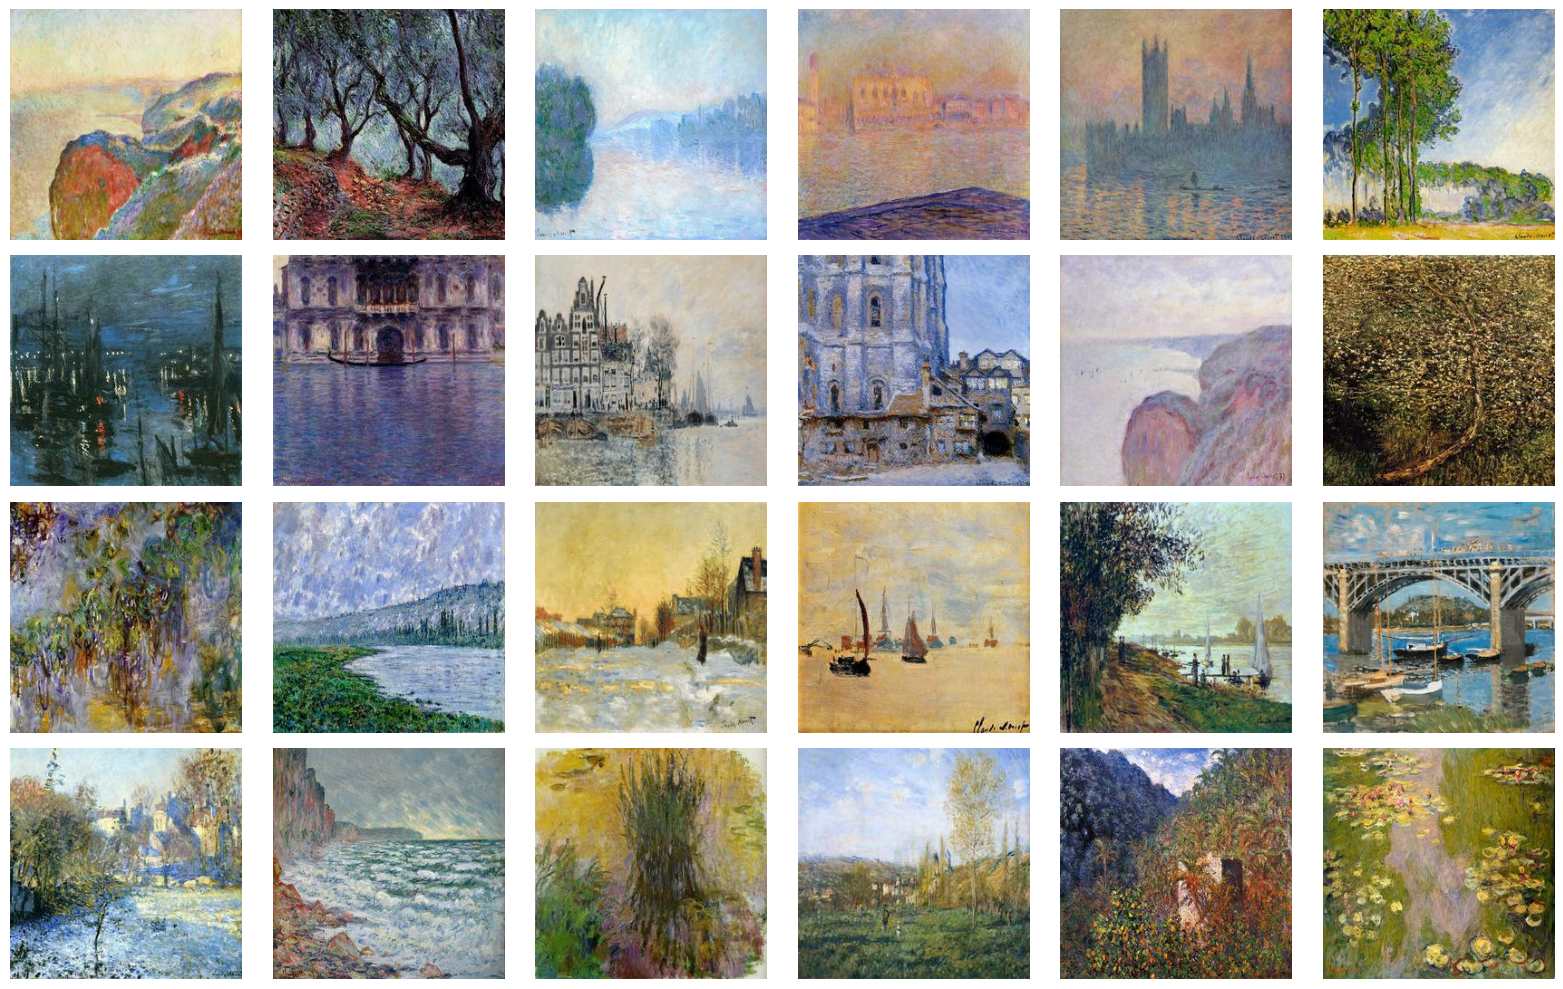

In [59]:
display_images(monet_images_path, 4, 6)

Photos

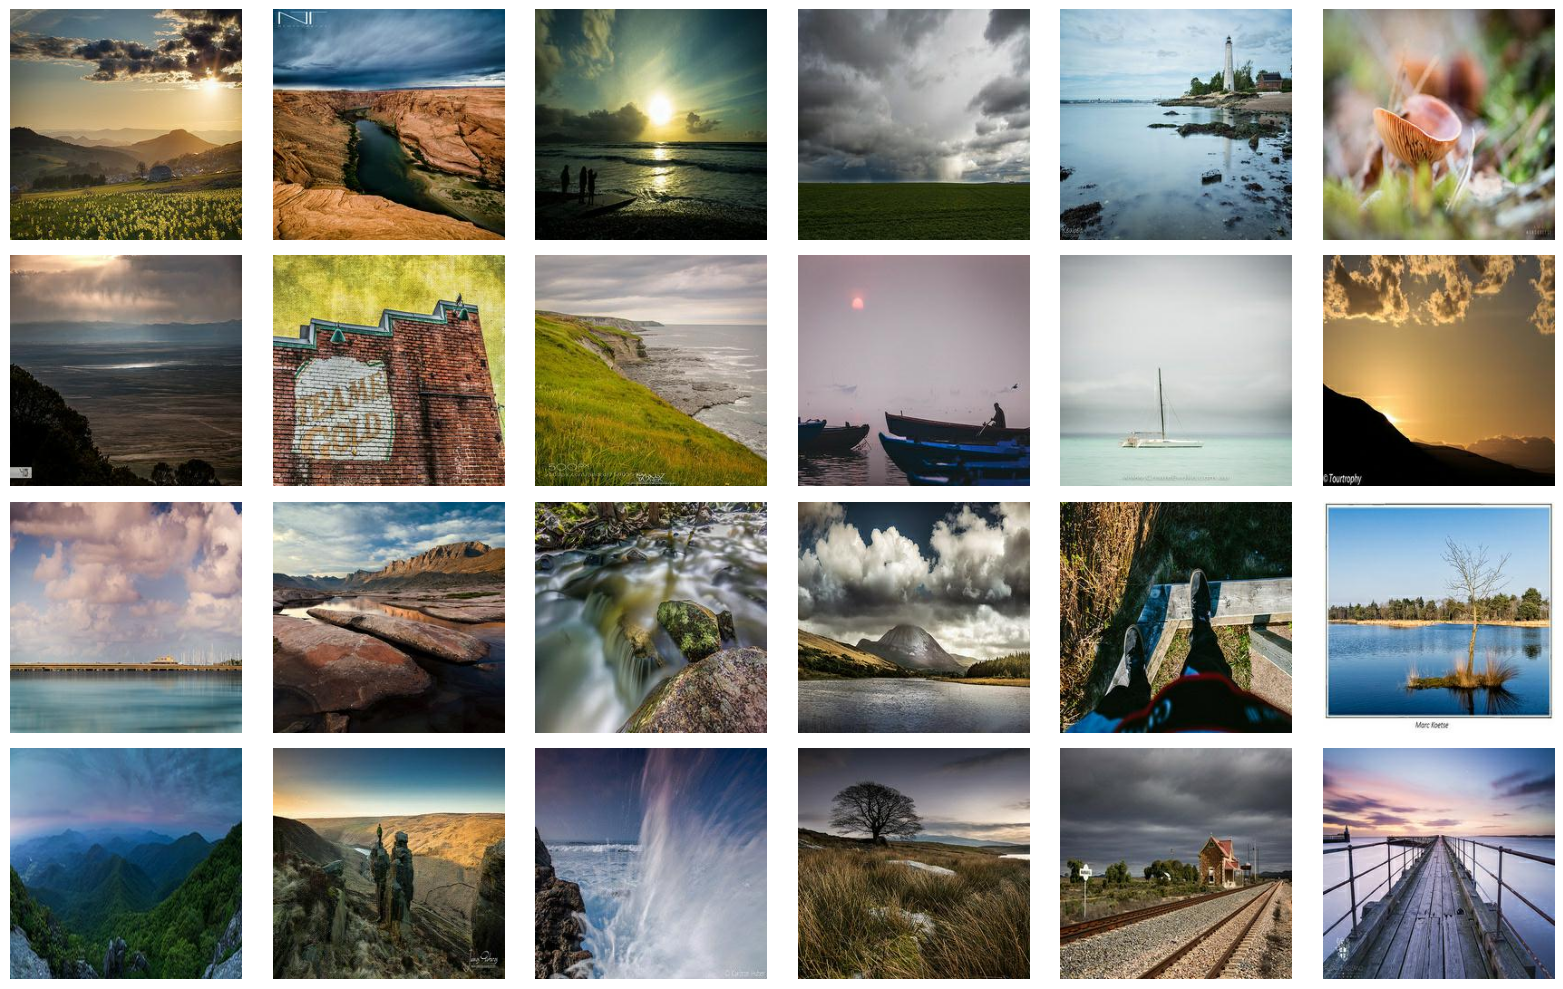

In [60]:
display_images(photo_images_path, 4, 6)

---

## Model Architecture

Now that we have taken a look at the paintings and images, let work on setting up our Regular GAN model to train on the paintings and apply it to the photos. As mentioned above, this architecture is based of the Monet CycleGAN Tutorial notebook by Amy Wang(link - https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook). I have modified the code to work on a Regular GAN model as opposed to her CycleGAN.

Regular GAN: In a regular GAN, you have a generator network and a discriminator network. The generator's objective is to generate data (e.g., images) that is indistinguishable from real data, while the discriminator's objective is to distinguish between real and generated data.

CycleGAN: CycleGAN, on the other hand, is designed for image-to-image translation tasks. It aims to learn a mapping between two domains (e.g., photos and Monet-style paintings) such that an image from one domain can be translated into the other domain and then back again without significant loss of quality. It consists of two generators and two discriminators, one for each domain.

Regular GAN typically consists of a single generator and a single discriminator, while CycleGAN consists of two generators (one for each domain) and two discriminators (one for each domain). It also incorporates cycle consistency loss to ensure that the mapping is bidirectional and that images can be translated back and forth. I chose a Regular GAN as you needed to generate data samples that are similar to the monet paintings dataset and it was faster.

In [61]:
MONET_FILENAMES = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))

#### Helper functions

In [62]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [63]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

The downsample function creates a downsampling layer that reduces the spatial dimensions of input feature maps through convolution, optional instance normalization, and Leaky ReLU activation. Conversely, the upsample function creates an upsampling layer that enlarges feature maps through transposed convolution, instance normalization, optional dropout, and ReLU activation. These functions play a crucial role in defining the architecture of generator and discriminator networks, allowing for effective image generation and translation in deep learning models.

In [64]:
# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(L.Dropout(0.5))
    result.add(L.ReLU())

    return result

#### Generator function

In [65]:
OUTPUT_CHANNELS = 3

def generator():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), 
        downsample(128, 4),                          
        downsample(256, 4),                          
        downsample(512, 4),                          
        downsample(512, 4),                          
        downsample(512, 4),                          
        downsample(512, 4),                          
        downsample(512, 4),                         
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4),                     
        upsample(256, 4),                     
        upsample(128, 4),                     
        upsample(64, 4),                      
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

#### Discriminator function

In [66]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')
    
    x = inp
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = L.ZeroPadding2D()(x)
    x = L.Conv2D(512, 4, strides=1,
                 kernel_initializer=initializer,
                 use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = L.LeakyReLU()(x)
    x = L.ZeroPadding2D()(x)
    x = L.Conv2D(1, 4, strides=1,
                 kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=x)

The code below forms a basic GAN model that trains a generator to produce Monet-style paintings from real Monet paintings while training a discriminator to distinguish between real and fake paintings. This adversarial training process helps the generator improve its ability to generate realistic Monet-style artwork. We also define several loss functions and a custom early stopping callback within a strategy.scope(). 

In [73]:
with strategy.scope():
    monet_generator = generator()
    photo_discriminator = discriminator()

class RegularGan(Model):
    def __init__(self, generator, discriminator):
        super(RegularGan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn):
        super(RegularGan, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    def train_step(self, batch_data):
        real_monet, _ = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake Monet paintings
            fake_monet = self.generator(real_monet, training=True)

            # Discriminator evaluation
            disc_real_monet = self.discriminator(real_monet, training=True)
            disc_fake_monet = self.discriminator(fake_monet, training=True)

            # Calculate losses
            gen_loss = self.gen_loss_fn(disc_fake_monet)
            disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)

        # Calculate gradients and apply to optimizers
        gen_gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }

In [68]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss


In [69]:
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, monitor_loss='loss', min_delta=0, patience=0, verbose=0):
        super().__init__(monitor=monitor_loss, min_delta=min_delta, patience=patience, verbose=verbose)

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is None:
            warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '
                          f'which is not available. Available metrics are: {",".join(list(logs.keys()))}',
                          RuntimeWarning)
            return

        if np.greater(current_loss - self.min_delta, self.best).all():
            self.best = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f'Early stopping triggered at epoch {epoch} due to loss {self.monitor}.')

# Example usage
early_stopping = CustomEarlyStopping(monitor_loss='monet_disc_loss', patience = 20, min_delta=0.001)

The code below sets up and trains a regular GAN model using TensorFlow and Keras, with the goal of generating Monet-style images from input photos while optimizing generator and discriminator networks. The training process is controlled by optimizer settings, loss functions, and early stopping criteria.

In [76]:
with strategy.scope():
    gen_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    gan_model = RegularGan(monet_generator, photo_discriminator)

    gan_model.compile(gen_optimizer=gen_optimizer,
                      disc_optimizer=disc_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss)

    history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE),
                            steps_per_epoch=(len(monet_images_path) // BATCH_SIZE),
                            epochs=5,
                            verbose=1,
                            callbacks=[early_stopping]).history

Epoch 1/5
300/300 [==============================] - 341s 1s/step - gen_loss: 0.7230 - disc_loss: 0.6850
Epoch 2/5


C:\Users\pramo\AppData\Local\Temp\ipykernel_8768\2973411601.py:8: RuntimeWarning: Early stopping conditioned on metric `monet_disc_loss` which is not available. Available metrics are: gen_loss,disc_loss
  warnings.warn(f'Early stopping conditioned on metric `{self.monitor}` '


300/300 [==============================] - 330s 1s/step - gen_loss: 0.7267 - disc_loss: 0.6775
Epoch 3/5
300/300 [==============================] - 330s 1s/step - gen_loss: 0.8036 - disc_loss: 0.6419
Epoch 4/5
300/300 [==============================] - 332s 1s/step - gen_loss: 0.9118 - disc_loss: 0.5988
Epoch 5/5
300/300 [==============================] - 335s 1s/step - gen_loss: 1.0078 - disc_loss: 0.5700


The training log provided displays the progression of a Generative Adversarial Network (GAN) training process over five epochs. During training, the generator's loss (gen_loss) steadily increases from epoch to epoch, indicating that it becomes progressively challenging for the generator to produce Monet-style images convincing enough to deceive the discriminator. Conversely, the discriminator's loss (disc_loss) decreases as it improves its ability to differentiate real Monet-style images from generated ones. This dynamic showcases the competitive nature of GAN training, where the generator and discriminator continuously adapt in opposition.


Now that we have trained our model, let us use it to take a few example photos and try to convert them into monet style images.

In [77]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

1/1 [==============================] - 1s 850ms/step


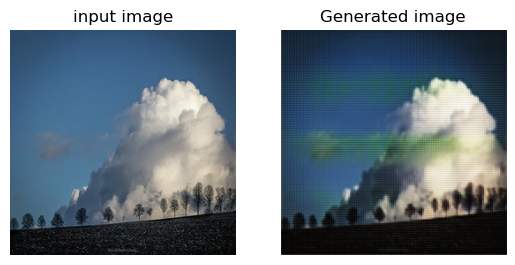

1/1 [==============================] - 0s 197ms/step


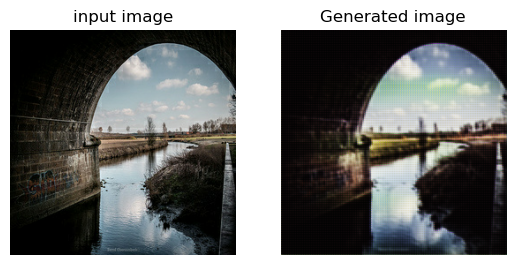

1/1 [==============================] - 0s 192ms/step


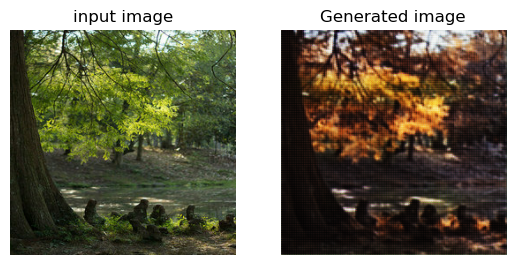

1/1 [==============================] - 0s 186ms/step


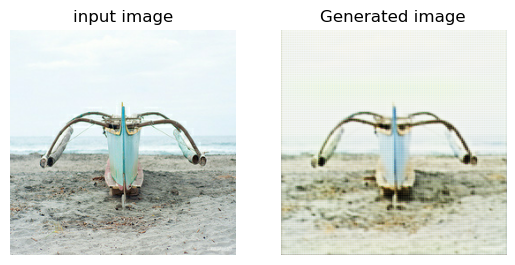

In [78]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 4)

As you can see, its not bad. Its close to the monet-style, but theres seems to be green streaks on the generated images. This shows that the generated images may be improved by adjusting the training parameters and hyperparameters.

Lets use this model to predict on the photos and save it.

In [79]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [80]:
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [84]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038


## 5. Conclusion

In conclusion, this project aimed to generate Monet-style paintings using a Regular GAN trained on a dataset of Monet paintings. The model was trained for five epochs, and the training progress was monitored with respect to generator and discriminator losses. While the model was successful in generating images that resembled Monet's style, some generated images exhibited green streaks, indicating room for improvement. This project serves as a starting point for generating Monet-style artwork, and further refinements can lead to even more convincing and visually appealing results.

Github link - https://github.com/pramodhgopal/Monet-Paintings-GAN


<br>
<br>

**References**:

Amy Jang, "Monet CycleGAN Tutorial on Kaggle," Kaggle, URL: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook